In [5]:
import os
import glob
import numpy as np
import trimesh
import binvox_rw
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import Conv3D, Dense, Flatten, Reshape,MaxPool3D,GlobalAveragePooling3D,BatchNormalization,Dropout,LeakyReLU
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping,Callback,ModelCheckpoint
from time import time
import itertools
import seaborn as sns
import pandas as pd
from pretty_confusion_matrix import pp_matrix_from_data

In [3]:
path = r'/ocean/projects/mch210006p/mhrahman/Main'
folders = glob.glob(os.path.join(path,'*'))
Classes = []
for i in folders:
    cls = os.path.basename(i)
    Classes.append(cls)

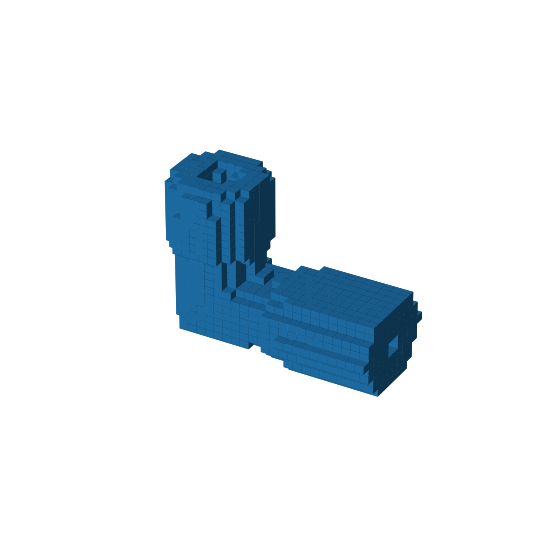

In [23]:
with open(os.path.join(path,'Elbow_fitting/train/00021151.binvox'),'rb') as vox:
    data = np.int32(binvox_rw.read_as_3d_array(vox).data)
    padded_data = np.pad(data,3, 'constant')
ax = plt.figure(figsize=(15,10)).add_subplot(111,projection='3d')
ax.voxels(padded_data)
ax.set_axis_off()
plt.savefig('/jet/home/mhrahman/Projects/Project/Voxnet/Figures/Voxel.jpg',dpi = 300)
plt.show()

In [4]:
length = []
for i, folder in enumerate(folders):
    train_files = glob.glob(os.path.join(folder,"train/*obj"))
    val_files = glob.glob(os.path.join(folder,"val/*obj"))
    test_files = glob.glob(os.path.join(folder,"test/*obj"))
    a = len(train_files) + len(val_files) + len(test_files)
    length.append(a)

In [5]:
data_count = pd.DataFrame({'Name': Classes, "Count":length})
data_count.to_csv('Data_count',index= False)

In [44]:
np.sum(length)

51638

In [6]:
X = {'train':[],'val': [],'test':[]}
Y = {'train':[],'val':[],'test':[]}
for label,cl in enumerate(Classes):
    for split in ['train','val','test']:
        example_dir = os.path.join(path,cl,split)
        for example in os.listdir(example_dir):
            if 'binvox' in example:
                with open(os.path.join(example_dir,example),'rb') as file:
                    data = np.int32(binvox_rw.read_as_3d_array(file).data)
                    padded_data = np.pad(data,3, 'constant')
                    X[split].append(padded_data)
                    Y[split].append(label)

In [17]:
X_train, Y_train = shuffle(X['train'],Y['train'])
X_test, Y_test = shuffle(X['test'],Y['test'])
X_val, Y_val = shuffle(X['val'],Y['val'])

In [24]:
t = np.array(X_train)

In [25]:
X_train = np.reshape(t,(t.shape[0],t.shape[1],t.shape[2],t.shape[3],1))

In [26]:
X_val = np.reshape(np.array(X_val),
                  (np.array(X_val).shape[0],
                  np.array(X_val).shape[1],
                  np.array(X_val).shape[2],
                  np.array(X_val).shape[3], 1))

In [19]:
X_test = np.reshape(np.array(X_test),
                  (np.array(X_test).shape[0],
                  np.array(X_test).shape[1],
                  np.array(X_test).shape[2],
                  np.array(X_test).shape[3], 1))

In [16]:
Y_train, Y_val = tf.keras.utils.to_categorical(Y_train,len(Classes)), tf.keras.utils.to_categorical(Y_val,len(Classes))

In [15]:
y_test = tf.keras.utils.to_categorical(Y_test,len(Classes))

In [15]:
model_base = Sequential([
    Conv3D(filters= 16,kernel_size=6, strides=2, activation='relu',input_shape = (30,30,30,1)),
    Conv3D(filters= 64, kernel_size=5, strides=2, activation='relu'),
    Conv3D(filters= 64, kernel_size= 5, strides= 2, activation= 'relu'),
    Flatten(),
    Dense(len(Classes), activation = 'softmax')
])

In [7]:
model_conv = Sequential([
    Conv3D(filters= 32, kernel_size=5, strides=2, activation='relu', input_shape =(30,30,30,1)),
    MaxPool3D(pool_size= 2),
    Conv3D(filters=64, kernel_size=3, strides= 1, activation= 'relu'),
    MaxPool3D(pool_size=2),
    Flatten(),
    Dense(units= 512, activation='relu'),
    Dense(units=len(Classes), activation= 'softmax')
])

In [6]:
model_deep = Sequential([
    Conv3D(filters= 32, kernel_size=5, strides=1, input_shape =(30,30,30,1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Conv3D(filters=64, kernel_size=3, strides=1),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPool3D(pool_size=2),
    Conv3D(filters=128, kernel_size=3,strides=1),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPool3D(pool_size=2),
    Flatten(),
    Dense(units=256, activation='relu'),
    Dense(units=len(Classes), activation='softmax')
])

In [ ]:
class TimeCallback(Callback):
    def on_train_begin(self,logs={}):
        self.logs=[]
    def on_epoch_begin(self,epoch,logs={}):
        self.starttime = time()
    def on_epoch_end(self,epoch,logs={}):
        self.logs.append(time()-self.starttime)
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1, patience = 20,min_delta = 1)
cb = TimeCallback()
checkpoints = ModelCheckpoint('weight_deep.hdf5',monitor='accuracy',verbose=1,save_best_only= True,mode='max')

In [16]:
model = model_deep
model.compile(loss = 'categorical_crossentropy',optimizer = tf.keras.optimizers.Adam(lr = 0.001),
             metrics = ['accuracy'])
model.summary()
with open('modelsummary_2.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 13, 13, 13, 16)    3472      
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 5, 5, 5, 64)       128064    
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 1, 1, 1, 64)       512064    
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                2665      
Total params: 646,265
Trainable params: 646,265
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_history = model.fit(X_train,Y_train, batch_size = 256, epochs = 100, 
                          validation_data = (X_val,Y_val),
                          shuffle = True,
                         callbacks = [es,cb,checkpoints])

Train on 20402 samples, validate on 5101 samples
Epoch 1/30
  256/20402 [..............................] - ETA: 14:34

KeyboardInterrupt: 

In [ ]:
#plot training and validation curve
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r')
plt.plot(epochs,val_acc,'b')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.savefig('/jet/home/mhrahman/Projects/Project/Voxnet/Figures/Classification_acc.jpg',dpi = 300)
plt.show()


plt.plot(epochs,loss,'r')
plt.plot(epochs,val_loss,'b')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(["Training loss","Validation loss"])
plt.savefig('/jet/home/mhrahman/Projects/Project/Voxnet/Figures/Classification_loss.jpg',dpi = 300)
plt.show()

In [12]:
from tensorflow.keras.models import load_model
model_load = Sequential()
model_load = load_model('weight.hdf5')

In [20]:
Y_pred = np.argmax(model_load.predict(X_test.astype('float32')),axis = 1)

In [21]:
conf = confusion_matrix(Y_test,Y_pred)

In [22]:
df = pd.DataFrame(conf,index=Classes,columns=Classes)

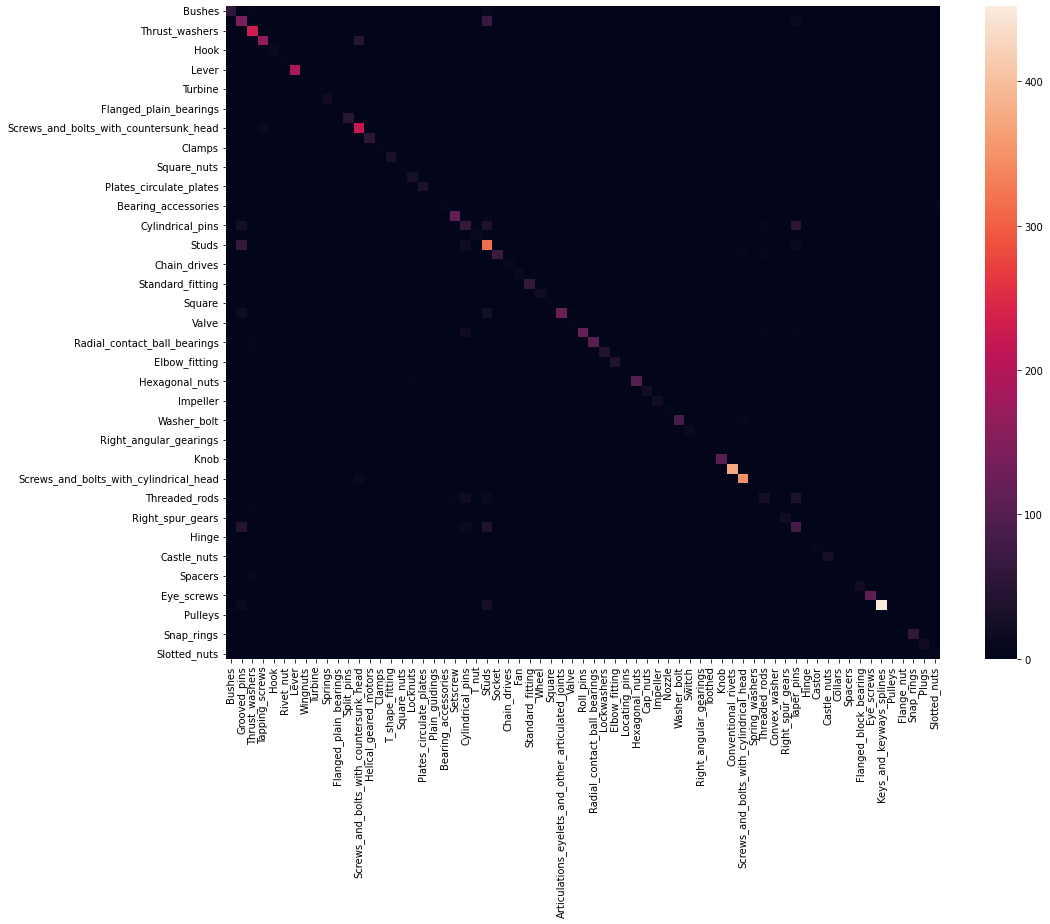

In [23]:
plt.figure(figsize=(16,12))
sns.heatmap(df)
plt.savefig(r'/jet/home/mhrahman/Projects/Project/Voxnet/Figures/Heat.jpg',dpi = 300)

In [43]:
class_report = classification_report(Y_pred,Y_test,output_dict=True)
report_df = pd.DataFrame(class_report).transpose()
report_df.to_csv('Report.csv')

,precision,recall,f1-score,support
0,0.717949,0.746667,0.732026,75.000000
1,0.626667,0.439252,0.516484,321.000000
2,0.987179,0.849265,0.913043,272.000000
3,0.753425,0.942857,0.837563,175.000000
4,0.538462,0.636364,0.583333,22.000000
...,...,...,...,...
65,1.000000,0.900000,0.947368,20.000000
66,0.888889,0.615385,0.727273,13.000000
accuracy,0.789832,0.789832,0.789832,0.789832
macro avg,0.671799,0.744803,0.690347,5429.000000


In [24]:
y_score = tf.keras.utils.to_categorical(Y_pred,len(Classes))

In [25]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(Classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:,i],y_score[:,i])
    average_precision[i] = average_precision_score(y_test[:,i],y_score[:,i])
precision["micro"], recall["micro"],_ = precision_recall_curve(y_test.ravel(),y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")

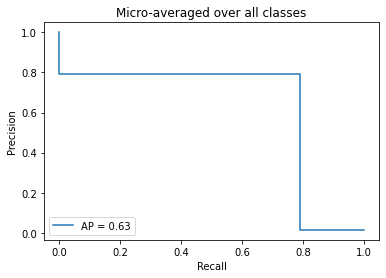

In [26]:
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")
plt.savefig(r'/jet/home/mhrahman/Projects/Project/Voxnet/Figures/Pr_Re.jpg', dpi = 300)